In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.metrics import precision_recall_fscore_support

data= fetch_openml('mnist_784', version=1, parser="auto")#Get data from https://www.openml.org/d/554
dfData = pd.DataFrame(np.c_[data["data"],data["target"]],columns = data["feature_names"]+["target"])

In [4]:
stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_index, test_index in stratSplit.split(dfData[data["feature_names"]], dfData["target"]):
    X_train = dfData[data["feature_names"]].iloc[train_index]
    X_test = dfData[data["feature_names"]].iloc[test_index]

    y_train = dfData["target"].iloc[train_index]
    y_test = dfData["target"].iloc[test_index]

In [5]:
from sklearn.linear_model import LogisticRegression
logReg_clf = LogisticRegression()

In [6]:
from sklearn.model_selection import cross_validate

#cross validation: does not only show the average but also the variation your model's got
results = cross_validate(logReg_clf,
                         X = X_train,
                         y=y_train,
                         #multi class method: roc_auc one vs. rest weighted
                        scoring = ["accuracy","roc_auc_ovr_weighted","f1_macro"],

                         #macro - unweighted mean of metrics per label
                         #weighted - weighted mean of metrics per label based on support
                         #Full list of scoring metrics can be found here
                         #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

                        #cv: number of cross-validations we do (number of data splits)
                        cv = 5,#If our estimator is classifier automatically do stratified CV
                        n_jobs=-1,#Num CPUs to use for calculation, -1 means all
                        verbose = True,#Output status updates
                        return_train_score=True,
                        return_estimator=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished


In [7]:
results.keys()
#fit time: time to do the process
#score time: time to do the score
#estimator: trained model for the iteration
#test accuracy: accuracy test set
#train accuracy: accuracy training set
#train/test auc: auc score on test and training set
#f1: using macro average

dict_keys(['fit_time', 'score_time', 'estimator', 'test_accuracy', 'train_accuracy', 'test_roc_auc_ovr_weighted', 'train_roc_auc_ovr_weighted', 'test_f1_macro', 'train_f1_macro'])

In [11]:
#call keys for further information
print(results["fit_time"])
print(results["estimator"])

[43.14268041 41.2826798  44.44116998 43.46126652 24.45976329]
[LogisticRegression(), LogisticRegression(), LogisticRegression(), LogisticRegression(), LogisticRegression()]


In [12]:
#average accuracy f1 score
print(np.mean(results["test_f1_macro"]))

#Variation in our predictions: how much our performance varies (standard deviation)
print(np.std(results["test_f1_macro"]))

0.9169675109415083
0.0014324470413433154


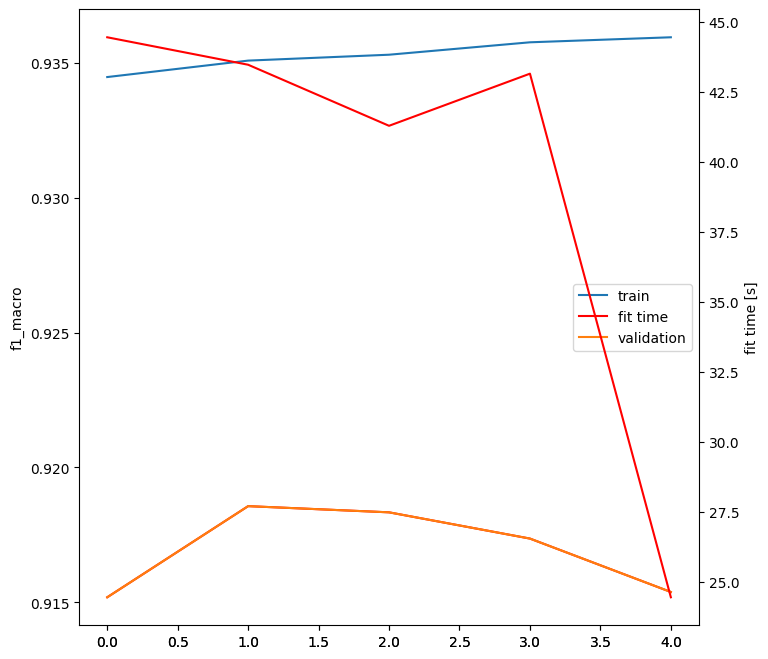

In [13]:
cvData = {"val":results["test_f1_macro"], #validation scores
        "train":results["train_f1_macro"], #test f1 scores
        "fit_time":results["fit_time"]} #fit times

dfCV = pd.DataFrame(cvData).sort_values("train").reset_index(drop=True)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
plt.plot(dfCV.index,dfCV["train"],label="train")
ax.plot(dfCV.index,dfCV["val"],color="red",label="fit time")
plt.plot(dfCV.index,dfCV["val"],label='validation')
plt.ylabel("f1_macro")
plt.legend()

ax2 = fig.add_subplot(111, sharex=ax, frameon=False)
ax2.plot(dfCV.index,dfCV["fit_time"],color="red",label="fit time")
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('fit time [s]')

plt.show()

#result: train score goes up, validation score goes down
#performing worse on data it hasen't seen before (sign of overfitting!)

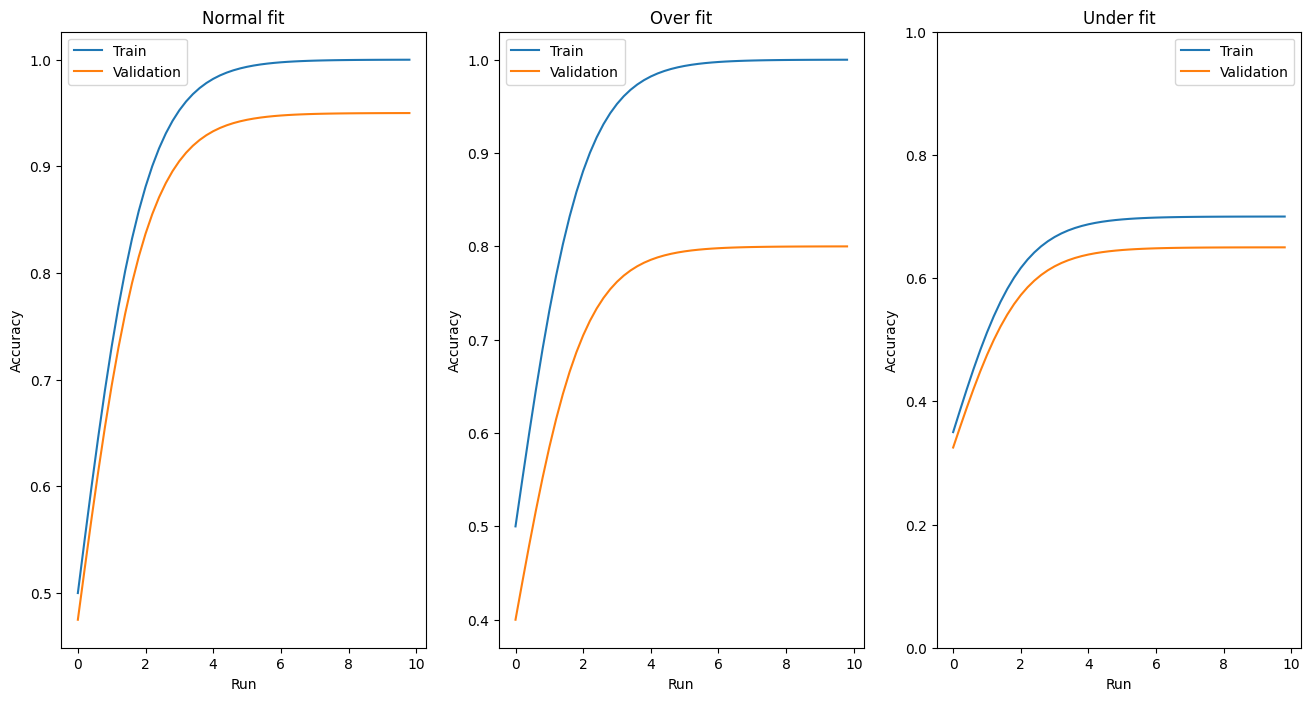

In [14]:
#example: showing different curves of normal fittig + overfitting + underfitting
#normal fit: train close to 1.0, validation close below the train curve
#overfitting: model performs well on the data but doesn't generalize well, large gap (learns the data too well)
#underfitting: model performs poor on the training set as well as on the validation set (model hasn't properly learned from the data and doesn't do well on the data it has already seen)
x = np.arange(0,10,.2)
fig = plt.figure(figsize=(16,8))
fig.add_subplot(131)
plt.title("Normal fit")
plt.plot(x,1/(1+np.exp(-x)),label="Train")
plt.ylabel("Accuracy")
plt.xlabel("Run")
plt.plot(x,0.95/(1+np.exp(-x)),label="Validation")
plt.legend()
fig.add_subplot(132)
plt.title("Over fit")
plt.plot(x,1/(1+np.exp(-x)),label="Train")
plt.ylabel("Accuracy")
plt.xlabel("Run")
plt.plot(x,0.8/(1+np.exp(-x)),label="Validation")
plt.legend()

fig.add_subplot(133)
plt.title("Under fit")
plt.plot(x,.7/(1+np.exp(-x)),label="Train")
plt.ylabel("Accuracy")
plt.xlabel("Run")
plt.plot(x,0.65/(1+np.exp(-x)),label="Validation")
plt.legend()

plt.ylim(0,1)
plt.show()

In [15]:
#accessing the model on the 2nd iteration index [1]
results["estimator"][1].predict(X_train)

array(['9', '0', '6', ..., '5', '4', '5'], dtype=object)